In [1131]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None # to turn off the chained assignments

_________________________________
Import inventories dataframe

In [1132]:
df_inventories = pd.concat(
    map(pd.read_csv, ['data/lego_sets_2012.csv', 'data/lego_sets_2013.csv', 'data/lego_sets_2014.csv', 'data/lego_sets_2015.csv', 'data/lego_sets_2016.csv', 'data/lego_sets_2017.csv', 'data/lego_sets_2018.csv', 'data/lego_sets_2019.csv', 'data/lego_sets_2020.csv', 'data/lego_sets_2021.csv', 'data/lego_sets_2022.csv']), ignore_index= True)

In [1133]:
df_inventories.describe()

,Year,Minifigs,Pieces,RRP (GBP),RRP (USD),RRP (CAD),RRP (EUR),EAN,UPC,Width,...,Flag 1 not used,Flag 2 not used,Flag 3 not used,Flag 4 not used,Flag 5 not used,Flag 6 not used,Flag 7 not used,Flag 8 not used,Value new (USD),Value used (USD)
count,8960.000000,4380.000000,6623.000000,5518.000000,5978.000000,4959.000000,4311.000000,4.591000e+03,4.048000e+03,4999.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6223.000000,4863.000000
mean,2017.201897,2.711187,293.742111,31.808079,35.732753,50.414866,40.653957,5.570997e+12,6.733013e+11,26.001103,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.807138,35.659745
std,3.110600,2.777822,589.358683,47.871629,55.157096,70.917301,59.315827,8.015292e+11,1.716260e+10,13.951904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.057426,65.366815
min,2012.000000,1.000000,0.000000,0.000000,0.000000,2.490000,0.010000,6.734191e+11,1.826580e+11,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.050000,0.250000
25%,2015.000000,1.000000,29.000000,7.990000,8.230000,13.990000,9.990000,5.702015e+12,6.734192e+11,14.100000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.495000,5.360000
50%,2017.000000,2.000000,96.000000,17.990000,19.990000,24.990000,19.990000,5.702016e+12,6.734193e+11,25.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.640000,14.150000
75%,2020.000000,3.000000,316.500000,34.990000,39.990000,54.990000,49.990000,5.702017e+12,6.734193e+11,35.407600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.110000,37.230000
max,2022.000000,32.000000,11695.000000,734.990000,849.990000,1049.990000,849.990000,9.788325e+12,8.839294e+11,116.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9000.000000,1329.050000


Import scraped Ebay data dataframe

In [1134]:
df_ebay = pd.read_csv('lego_ebay_sold_price.csv', parse_dates=True)

In [1135]:
df_ebay.describe()

,title,currency,sold_price,sold_date
count,15663,15574,15574,15737
unique,10080,2,3070,9
top,title,£,sold_price,10 Sep 2022
freq,257,15317,257,2968


___________________________________________________________________
EDA

CLEAN LEGO INVENTORIES DATA

Remove unused columns and copy to new DataFrame

In [1136]:
df_inventories_cleaned = df_inventories[['Number', 'Theme' , 'Minifigs', 'Pieces', 'RRP (GBP)', 'Launch date', 'Exit date']]

In [1137]:
df_inventories_cleaned.isnull().sum()

Number            0
Theme             0
Minifigs       4580
Pieces         2337
RRP (GBP)      3442
Launch date    4326
Exit date      4326
dtype: int64

Any missing RRP will be not useful in this analysis

So we drop them

In [1138]:
df_inventories_cleaned = df_inventories_cleaned[~df_inventories_cleaned['RRP (GBP)'].isna()]

We clean the set number to contain only the main code

In [1139]:
df_inventories_cleaned['Number'] = df_inventories_cleaned['Number'].str.replace(r'-\d+', '', regex=True)

In [1140]:
df_inventories_cleaned.head()

,Number,Theme,Minifigs,Pieces,RRP (GBP),Launch date,Exit date
0,3061,Friends,2.0,222.0,29.99,01/01/2012,31/12/2013
1,3063,Friends,1.0,195.0,19.99,01/06/2012,31/12/2013
2,3065,Friends,1.0,191.0,19.99,01/01/2012,31/12/2013
3,3183,Friends,1.0,130.0,14.99,01/01/2012,31/07/2013
4,3184,Friends,2.0,309.0,29.99,01/06/2012,31/12/2013


********************************************
CLEAN SCRAPED EBAY DATA

Extract all numbers found in title into columns

In [1141]:

# Extract all numbers in title to a list in a new DataFrame: normally LEGO's numbers code, number of pieces, set quantity, number of minifigures, etc.
df_numbers = df_ebay['title'].str.findall('([0-9]+)').to_list()

# Express all values in list to multi columns, each with one value.
# As with LEGO sets, the number of pieces is usually smaller than the actual number code. Other number are significantly smaller than the pieces and number code.
# Fill all nan value with 0, convert to int data type to find the max value

# df_numbers = df_ebay.numbers.apply(pd.Series).fillna(0).astype(int).max(axis=1)
df_numbers = pd.DataFrame([pd.Series(x, dtype = 'float') for x in df_numbers]).fillna(0).astype(int).max(axis=1) # Use this method to avoid the warning: 'The default dtype for empty Series will be 'object' instead of 'float64' in a future version warning'

In [1142]:
df_ebay_cleaned = df_ebay[['title', 'currency','sold_price', 'sold_date']]

In [1143]:
# Update the column 'numbers' with the correct value
df_ebay_cleaned.loc[:,'numbers'] = df_numbers
# Check null values in the set
df_ebay_cleaned.isnull().sum()

title          74
currency      163
sold_price    163
sold_date       0
numbers         0
dtype: int64

In [1144]:
# Remove duplicates
df_ebay_cleaned = df_ebay_cleaned.drop_duplicates()

Remove Outlier

Are those any invalid values: set number smaller than 999 and larger than 99999

In [1145]:
filter = ((df_ebay_cleaned['numbers'] < 999) | (df_ebay_cleaned['numbers'] > 99999))
filter.sum()

1796

There are invalid values. We're going to drop them.

In [1146]:
# Take only row with a valid numbers: number set is from 999 to 99999. 
df_ebay_cleaned = df_ebay_cleaned[~filter]
# Also we droped any row with sold_price is null
df_ebay_cleaned = df_ebay_cleaned[df_ebay_cleaned['sold_price'].notnull()]

In [1147]:
df_ebay_cleaned.head()

,title,currency,sold_price,sold_date,numbers
0,Lego STAR WARS MILLENNIUM FALCON BRAND NEW 135...,£,108.79,9 Sep 2022,75257
1,LEGO 40499 Santa's Sleigh (343 pcs) Brand New!...,£,67.73,9 Sep 2022,40499
2,LEGO 76208 Marvel Thor Love & Thunder. The Goa...,£,37.49,9 Sep 2022,76208
3,LEGO City 60161 - Jungle Exploration Site - BR...,£,145.0,9 Sep 2022,60161
4,Lego 75299 Trouble on Tatooine new factory sea...,£,22.0,9 Sep 2022,75299


***************************************************************************************************************************************************************


Exploratory Data Analysis

Top 20 sets sold on Ebay by frequency

In [1148]:
top_sets = df_ebay_cleaned['numbers'].value_counts().to_frame().reset_index().head(15)
top_sets.columns = ['set_numbers', 'frequency']
top_sets

,set_numbers,frequency
0,40515,80
1,40567,59
2,75267,51
3,71034,47
4,40530,46
5,71410,42
6,75342,34
7,71360,30
8,75290,30
9,71033,29


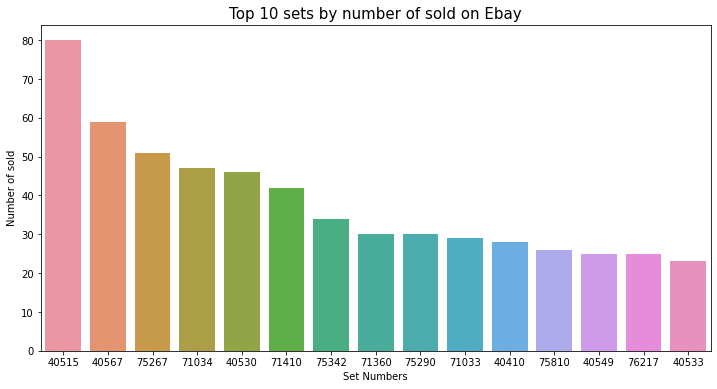

In [1149]:
fig, ax = plt.subplots(figsize = (12,6))
order_list = top_sets.sort_values('frequency', ascending=False).set_numbers
ax = sns.barplot(x = 'set_numbers', y = 'frequency', data = top_sets, order=order_list)
plt.title('Top 10 sets by number of sold on Ebay', size = 15)
plt.xlabel('Set Numbers')
plt.ylabel('Number of sold')
plt.show()

Take a deeper look at these sets specifically.

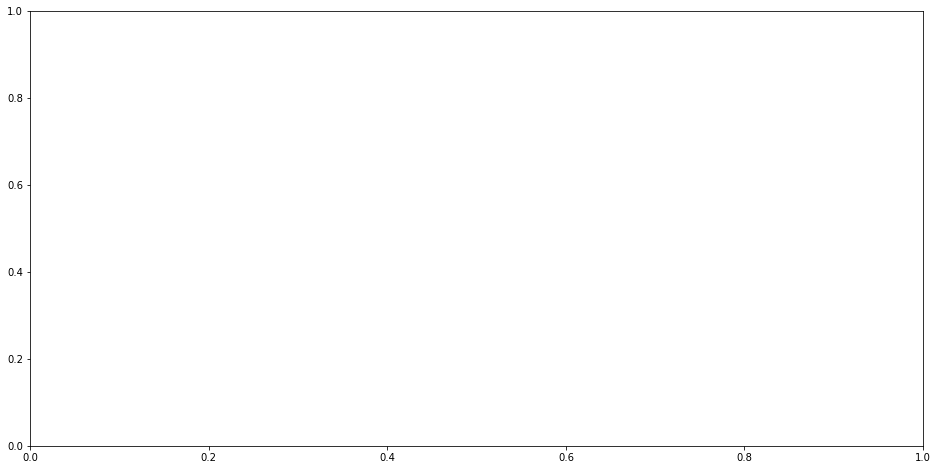

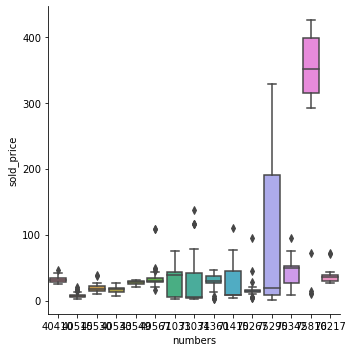

In [1162]:
# top_sets2 = df_ebay_cleaned[df_ebay_cleaned['numbers'].isin(top_sets['set_numbers'])]
cols = {'sold_price':'mean', 'sold_price':'std'}
# df_deep = df_ebay_cleaned[df_ebay_cleaned['numbers'].isin(top_sets['set_numbers'])].groupby('numbers', as_index=True).agg({'sold_price': ['mean','std', 'count']})
df_deep = df_ebay_cleaned[df_ebay_cleaned['numbers'].isin(top_sets['set_numbers'])]
fig2 = plt.subplots(figsize = (16,8))
sns.catplot(data=df_deep, kind='box', x='numbers', y='sold_price')
plt.show()

Convert sold price to float

In [1151]:
df_ebay_cleaned['sold_price'] = df_ebay_cleaned['sold_price'].astype(float)

Find unique product code in the scraped database

In [1152]:
df_ebay_cleaned['numbers'].nunique()

3242

In [1153]:
df_ebay_cleaned.groupby('numbers').mean()

,sold_price
numbers,
1017,2.420
1050,1.310
1051,4.330
1075,1.310
1078,4.240
...,...
98282,1.560
98283,8.140
99563,1.945


In [1154]:
df_ebay_cleaned.groupby('numbers').size()
# df_ebay.value_counts(['numbers'])
# need to check how to count rows in one group

numbers
1017     1
1050     1
1051     1
1075     2
1078     2
        ..
98282    1
98283    5
99563    2
99780    1
99781    1
Length: 3242, dtype: int64